# Mixture of Gaussian.

In this homework, we come to prepare something about Mixture of Gaussian (a.k.a. MoG).

Suppose we have some data points which are composed as multiple gaussians, say two.

Then the probablistic density function would be:

$$p(x) = \Sigma_{k=1}^K p(k)p(x|k)$$

$$p(x) = \Sigma_{k=1}^K \pi_k N(x| \mu_k, \Sigma_k)$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab

%matplotlib inline

In [2]:
def plot_multivariate_gaussian(mu, Sigma):
    """Given 2D Gaussian's mean and covariance, then its contour figure.
    
    Parameter:
    ------------
    1. mu: ndarray(2,), 2D Gaussian's mean vector.
    2. Sigma: ndarray(2, 2), 2D Gaussian's covariance matrix.
    
    Returns:
    ------------
    matplotlib figure with 2D Gaussian's contour.
    
    """
    delta = 3    # figure range.
    
    x, y = np.arange(mu[0]-delta, mu[0]+delta, .01), np.arange(mu[1]-delta, mu[1]+delta, .01)
    X, Y = np.meshgrid(x, y)
    pos  = np.dstack([X, Y])
    
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    fac = np.exp(-fac /2) / N
    plt.contour(X, Y, fac)

In [3]:
def compute_gaussian(x, mu, Sigma):
    """ Given Gaussian's parameters, mean and covariance, given data, compute probability.
    
    Parameter:
    ------------
    1. x: ndarray(2,), or (N, 2), data point or data matrix.
    1. mu: ndarray(K, 2), 2D Gaussian's mean vector.
    2. Sigma: ndarray(K, 2, 2), 2D Gaussian's covariance matrix.
    
    Returns:
    ------------
    1. prob. ndarray(K,) or(N, K). each column denotes K'th Gaussian component's probability.
    while, N denotes N data points.
    """
    prob = []
    K, D = mu.shape
    
    for k in range(K):
        Sigma_det = np.linalg.det(Sigma[k])
        Sigma_inv = np.linalg.inv(Sigma[k])
        
        denominator = np.sqrt((2*np.pi)**D * Sigma_det)
        fac = np.einsum('...k,kl,...l->...', x-mu[k], Sigma_inv, x-mu[k])
        
        prob.append(fac/denominator)
    
    prob = np.column_stack(prob)
    return prob

In [4]:
def init_param(K=2):
    """ Mixture of Gaussian, initialize all parameters,
    
    Parameters:
    ------------
    1. K: number of Gaussian components. (Where data's dimension D, is set to be 2.)
    
    Returns:
    ------------
    1. pPi: ndarray(K,), initial 1./K;
    2. pMiu: ndarray(K,D), initial random values range from [0, 1];
    3. pSigma: ndarray(K, D, D), initial identity matrix.
    """
    D = 2
    
    pPi = np.ones(K, dtype=np.float32) / K
    pMiu = np.random.rand(K, D)
    pSigma = np.empty((K, D, D))
    for i in range(K):
        pSigma[i] = np.identity(D) + np.random.rand(2,2)
    
    return pPi, pMiu, pSigma

In [5]:
def EM_algorithm(x, pPi, pMiu, pSigma):
    """ Given data and MoG's parameters, iteratively train Mixture of Gaussian.
    E-step:
        Given probability matrix, then, compute gamma(posterior probability.)
    M-step:
        Given gamma, then update all parameters.
        
    Parameters:
    ----------
    1. x: ndarray(N, D)
    2. pPi: ndarray(K, )
    3. pMiu: ndarray(K, D)
    4. pSigma: ndarray(K, D, D)
    
    Returns:
    1. pPi
    2. pMiu
    3. pSigma
    
    """
    prob = compute_gaussian(x, pMiu, pSigma)
    pGamma = prob * pPi
    pGamma = pGamma / np.sum(pGamma, axis=1)[:, np.newaxis]
    
    # update pPi.
    Nk = np.sum(pGamma, axis=0)
    pPi = Nk / np.sum(Nk)

    # update pMiu.
    pMiu = np.dot(pGamma.T, x) / Nk

    # update pSigma.
    for k in range(np.shape(pSigma)[0]):
        # pSigma[k] = np.einsum('k...,kl,l...->...', x-pMiu[k], np.diag(pGamma[:,k]), x-pMiu[k]) / Nk[k]
        pSigma[k] = np.dot((x-pMiu[k]).T, np.dot(np.diag(pGamma[:,k]), x-pMiu[k])) / Nk[k]
        
    return pPi, pMiu, pSigma

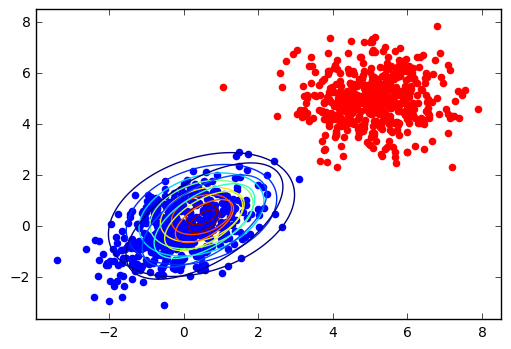

In [19]:
# Generate data points.

# Original data points.
mean_1 = np.array([0., 0.], dtype=np.float32)
cov_1 = np.array([[1., .5], [.5, 1.]], dtype=np.float32)
x1 = np.random.multivariate_normal(mean_1, cov_1, size=500)

mean_2 = np.array([5., 5.], dtype=np.float32)
cov_2 = np.array([[1., 0.], [0., 1.]], dtype=np.float32)
x2 = np.random.multivariate_normal(mean_2, cov_2, size=500)

x = np.vstack([x1,x2])

plt.scatter(x1[:,0], x1[:,1], color='b')
plt.scatter(x2[:,0], x2[:,1], color='r')

# Init params.
pPi, pMiu, pSigma = init_param()
for k in range(pMiu.shape[0]):
    plot_multivariate_gaussian(pMiu[k], pSigma[k])

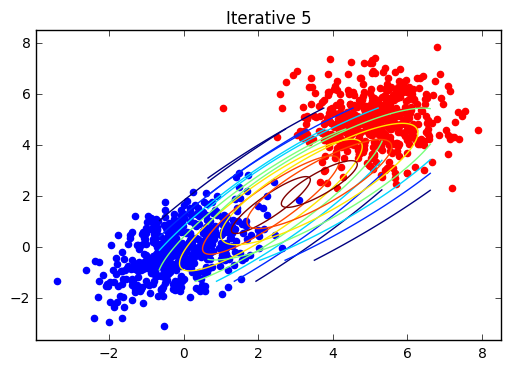

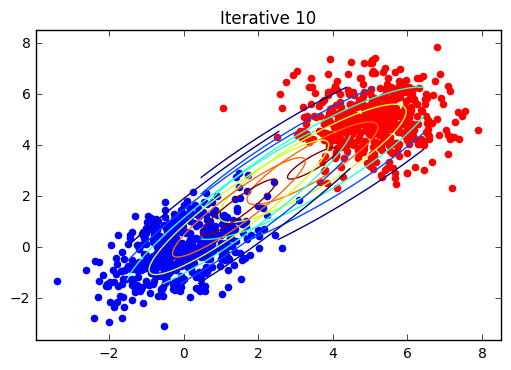

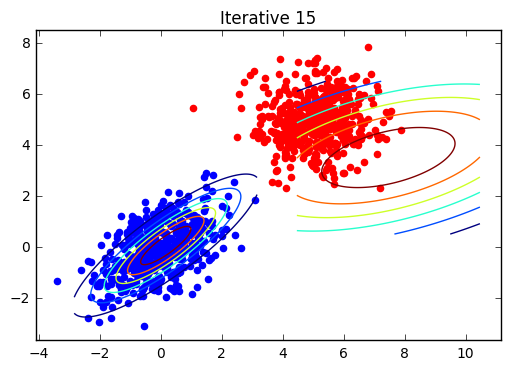

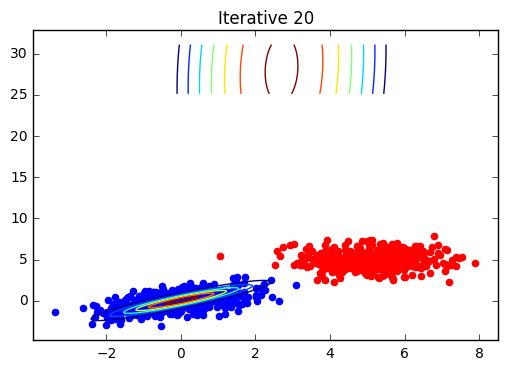

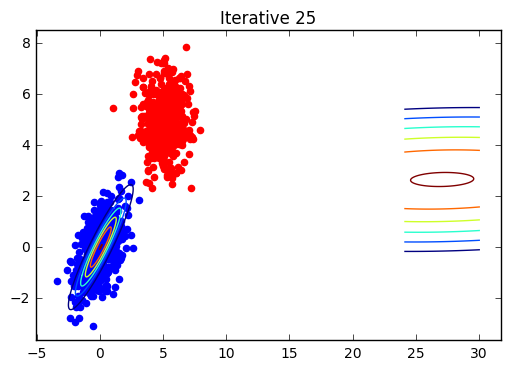

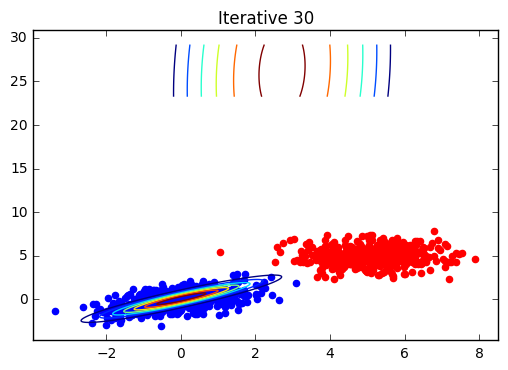

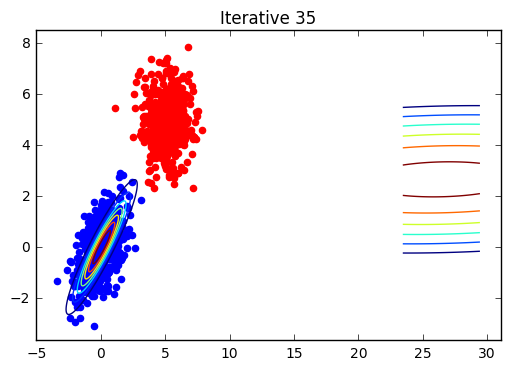

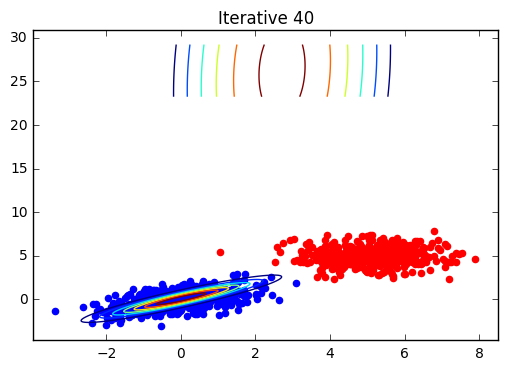

Final Reuslt:
Parameter PI: [ 0.90777256  0.09222744]
Parameter MIU: [[  2.71168179e+00   2.62507469e+01]
 [  1.20850986e-02   6.93294457e-02]]
Parameter SIGMA: [[[   7.4954881     6.64502777]
  [   6.64502777  563.46841977]]

 [[   1.74707674    1.63214643]
  [   1.63214643    1.78188695]]]


In [20]:
# Main function
max_iter = 40

for i in range(max_iter):
    pPi, pMiu, pSigma = EM_algorithm(x, pPi, pMiu, pSigma)

    # Plot figure.
    if (i+1) % 5 == 0:
        plt.scatter(x1[:,0], x1[:,1], color='b')
        plt.scatter(x2[:,0], x2[:,1], color='r')

        for k in range(pMiu.shape[0]):
            plot_multivariate_gaussian(pMiu[k], pSigma[k])
        plt.title("Iterative {}".format(i+1))
        plt.show()

print("Final Reuslt:\n" + "="*20)
print("Parameter PI: {}".format(pPi))
print("Parameter MIU: {}".format(pMiu))
print("Parameter SIGMA: {}".format(pSigma))

In [ ]:
## Deprecated code.

In [123]:
# E steps.

# Given probability matrix, then, compute gamma(posterior probability.)

prob = compute_gaussian(x, pMiu, pSigma)
pGamma = prob * pPi
pGamma = pGamma / np.sum(pGamma, axis=1)[:, np.newaxis]



In [124]:
# M steps.

# Given gamma, then update all parameters.

# update pPi.
Nk = np.sum(pGamma, axis=0)
pPi = Nk / np.sum(Nk)

# update pMiu.
pMiu = np.dot(pGamma.T, x) / Nk

# update pSigma.
for k in range(np.shape(pSigma)[0]):
    # pSigma[k] = np.einsum('k...,kl,l...->...', x-pMiu[k], np.diag(pGamma[:,k]), x-pMiu[k]) / Nk[k]
    pSigma[k] = np.dot((x-pMiu[k]).T, np.dot(np.diag(pGamma[:,k]), x-pMiu[k])) / Nk[k]

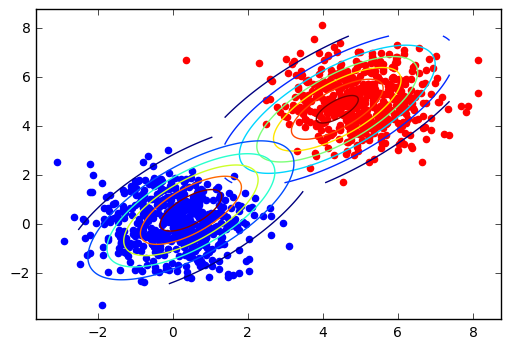

In [125]:
# Plot figure.
plt.scatter(x1[:,0], x1[:,1], color='b')
plt.scatter(x2[:,0], x2[:,1], color='r')

for k in range(pMiu.shape[0]):
    plot_multivariate_gaussian(pMiu[k], pSigma[k])